#### Does a high payment failure rate actually lead to churn?

##### Data Integration Merging behavioral metrics with player metadata to create a unified 'Churn Profile'

#### 1. Loading and Merging the Data

In [2]:
import pandas as pd

# Load the generated datasets
df_players = pd.read_csv('churn_players.csv')
df_behavior = pd.read_csv('churn_behavior.csv')

# Merge on player_id
# We use an 'inner' join to ensure we only analyze players with both profile and activity data
df_master = pd.merge(df_players, df_behavior, on='player_id', how='inner')

# Convert signup_date to datetime objects
df_master['signup_date'] = pd.to_datetime(df_master['signup_date'])

# Display the first few rows to verify the merge
print(f"Dataset Merged: {df_master.shape[0]} players and {df_master.shape[1]} features.")
df_master.head()

Dataset Merged: 2000 players and 8 features.


,player_id,signup_date,country,total_logins,avg_bet_size,payment_failure_rate,days_since_last_bet,churned
0,5000,2025-11-16,IN,77,427.374526,0.01,6,0
1,5001,2025-10-08,IN,146,494.007896,0.03,7,0
2,5002,2025-11-26,UK,29,6.748350,0.04,18,1
3,5003,2025-10-27,BR,145,203.712514,0.31,28,1
4,5004,2025-10-23,DE,104,378.744064,0.03,6,0


#### 2. EDA: Identifying the "Churn Driver"

##### Visualizing the relationship between payment failures and churned vs. active players.

C:\Users\Eldu\AppData\Local\Temp\ipykernel_16156\1540630630.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churned', y='payment_failure_rate', data=df_master, palette='RdYlGn_r')


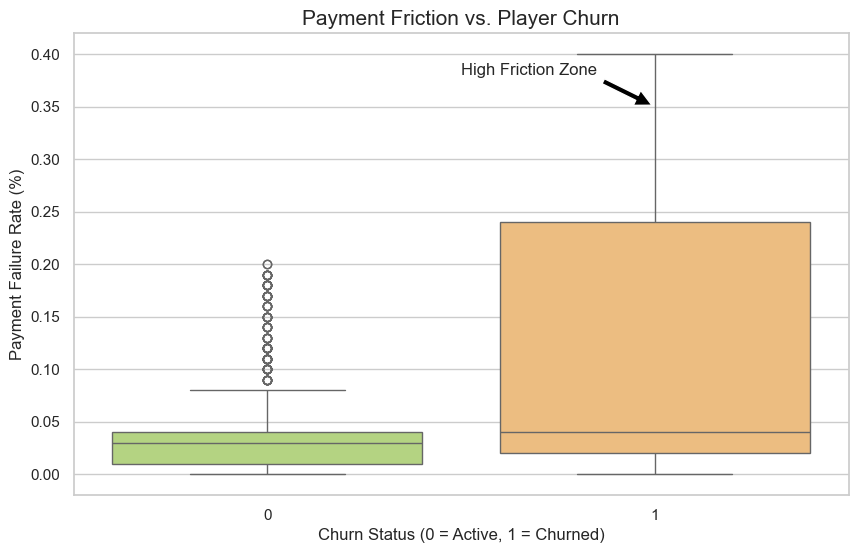

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional style
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

# Boxplot: Comparing Payment Failure Rates
sns.boxplot(x='churned', y='payment_failure_rate', data=df_master, palette='RdYlGn_r')

plt.title('Payment Friction vs. Player Churn', fontsize=15)
plt.xlabel('Churn Status (0 = Active, 1 = Churned)', fontsize=12)
plt.ylabel('Payment Failure Rate (%)', fontsize=12)

# Adding a note for stakeholders
plt.annotate('High Friction Zone', xy=(1, 0.35), xytext=(0.5, 0.38),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

##### Statistical Analysis of Churn Drivers
- Comparing the central tendencies of Active vs. Churned players to identify 'Red Flag' thresholds.

In [8]:
# Calculating key statistics for Friction and Behavior
churn_summary = df_master.groupby('churned').agg({
    'payment_failure_rate': ['mean', 'median', 'std', 'max'],
    'avg_bet_size': ['mean', 'median'],
    'days_since_last_bet': ['mean', 'median']
}).round(3)

# Renaming for clarity in the printout
churn_summary.index = ['Active (0)', 'Churned (1)']

print("CHURN DRIVER NUMERICAL SUMMARY")
print(churn_summary)

# Calculate the 'Friction Multiplier'
active_fail = churn_summary.loc['Active (0)', ('payment_failure_rate', 'mean')]
churn_fail = churn_summary.loc['Churned (1)', ('payment_failure_rate', 'mean')]
multiplier = churn_fail / active_fail

print(f"ANALYSIS: Churned players experience a {multiplier:.2f}x higher payment failure rate than active players.")

CHURN DRIVER NUMERICAL SUMMARY
            payment_failure_rate                    avg_bet_size           \
                            mean median    std  max         mean   median   
Active (0)                 0.033   0.03  0.034  0.2      174.919  123.346   
Churned (1)                0.119   0.04  0.132  0.4       63.876   31.071   

            days_since_last_bet         
                           mean median  
Active (0)                3.553    4.0  
Churned (1)              19.843   20.0  
ANALYSIS: Churned players experience a 3.61x higher payment failure rate than active players.


#### 3. Login Frequency Analysis

##### Analyzing if churned players showed a significant drop-off in login activity.

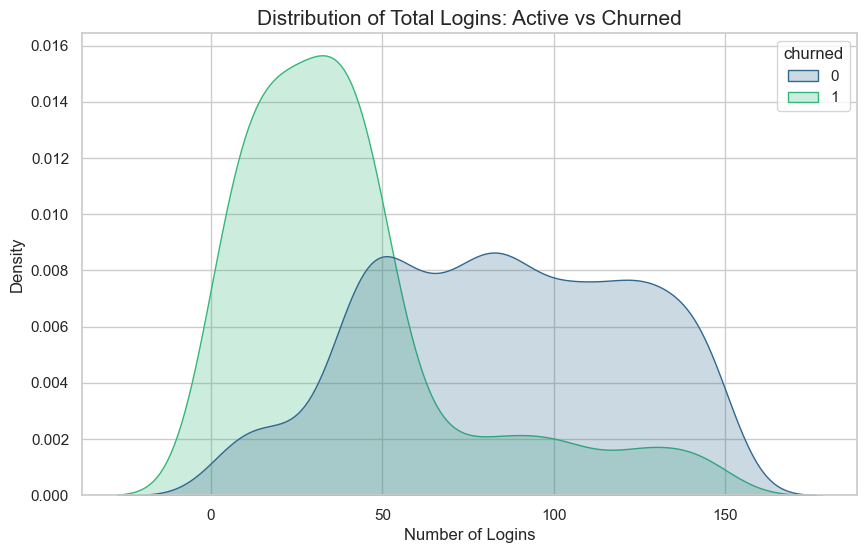

In [4]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_master, x="total_logins", hue="churned", fill=True, common_norm=False, palette="viridis")

plt.title('Distribution of Total Logins: Active vs Churned', fontsize=15)
plt.xlabel('Number of Logins', fontsize=12)
plt.show()

##### Numerical Insights: 
- Active vs. Churned Cohorts Calculating the specific behavioral differences to quantify the cost of churn.

In [6]:
# Group by churn status and calculate mean and median for key metrics
numerical_summary = df_master.groupby('churned').agg({
    'total_logins': ['mean', 'median', 'std'],
    'payment_failure_rate': ['mean', 'median'],
    'avg_bet_size': ['mean']
}).round(2)

print("Behavioral Comparison Table")
print(numerical_summary)

# Calculate the "Login Gap" ratio
active_avg = numerical_summary.loc[0, ('total_logins', 'mean')]
churned_avg = numerical_summary.loc[1, ('total_logins', 'mean')]
login_ratio = active_avg / churned_avg

print(f"\nKEY INSIGHT:")
print(f"Active players log in {login_ratio:.1f}x more often than churned players.")

# Calculate Friction impact
friction_increase = (numerical_summary.loc[1, ('payment_failure_rate', 'mean')] / 
                     numerical_summary.loc[0, ('payment_failure_rate', 'mean')])

print(f"Churned players experienced {friction_increase:.1f}x higher payment failure rates.")

Behavioral Comparison Table
        total_logins               payment_failure_rate        avg_bet_size
                mean median    std                 mean median         mean
churned                                                                    
0              85.15   85.0  37.64                 0.03   0.03       174.92
1              40.35   33.0  33.65                 0.12   0.04        63.88

KEY INSIGHT:
Active players log in 2.1x more often than churned players.
Churned players experienced 4.0x higher payment failure rates.


#### 1. The "Friction" Smoking Gun
- **The Data:** Churned players have a 3.61x higher payment failure rate.

- **The Insight:** Look at the max value for Active players (0.2) vs Churned (0.4). This suggests there is a "Breaking Point." Once a player experiences a failure rate above 20%, their patience runs out and they exit.

- **Business Action:** You should recommend that the Engineering team audits the payment gateway for any player hitting a 15% failure rate to "save" them before they churn.

#### 2. The "Engagement Gap"
- **The Data:** Active players log in 2.1x more often (85 vs 40 logins).

- **The Insight:** The median logins for churned players (33) is much lower than their mean (40). This tells us that many players churn very early on (low login counts pulling the median down), likely after their first few payment failures.

- **Business Action:** The first 30 logins are the "Danger Zone." If activity drops in this window, it's a high-priority churn signal.

#### 3. The "Wallet Share" Collapse
- **The Data:** Avg Bet Size for Active players ($174.92) vs Churned ($63.88).

- **The Insight:** Churned players aren't just logging in less; they are betting significantly smaller amounts. This usually indicates a "loss of confidence" in the platform.